### Fine-tuning TinyBERT for Sentiment Analysis

#### Introduction and Objective

The purpose of this notebook is to develop a sentiment analysis model using the TinyBERT architecture. Sentiment analysis, a key task in natural language processing (NLP), involves determining the sentiment expressed in a piece of text, such as positive, negative, or neutral. By leveraging the lightweight and efficient TinyBERT model, we aim to achieve accurate sentiment classification on a dataset of tweets. This analysis can provide valuable insights into public opinion and sentiment trends, which are crucial for various applications such as market analysis, customer feedback, and social media monitoring.

#### Required Datasets

Sentiment Analysis Data - [Kaggle Dataset](https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset?select=test.csv)

#### Dataset Overview

The dataset used in this project is sourced from Kaggle and contains text data from tweets, labeled with sentiment categories. The dataset provides a rich source of real-world text data that can be used to train and evaluate the TinyBERT model for sentiment analysis. Key features of the dataset include:

- **textID**: A unique identifier for each tweet in the dataset.
- **text**: The actual tweet content, which is the primary input for sentiment analysis.
- **selected_text**: The portion of the tweet that reflects the sentiment.
- **sentiment**: The label indicating the sentiment of the tweet, typically categorized as positive, negative, or neutral.
- **Time of Tweet**: The time when the tweet was posted, categorized into different periods of the day (morning, noon, night).
- **Age of User**: The age group of the user who posted the tweet.
- **Country**: The country from which the tweet was posted.
- **Population -2020**: The population of the country as of the year 2020.
- **Land Area (Km²)**: The land area of the country in square kilometers.
- **Density (P/Km²)**: The population density of the country per square kilometer.

#### Features Used

For this project, we will focus only on the **text** and **sentiment** fields, as these are directly relevant to our goal of sentiment classification. The **text** field serves as the input text that the TinyBERT model will analyze, and the **sentiment** field is the target variable for the classification task.

**Install Required Packages**:

   To enhance the functionality of the environment, you may need to install some libraries not pre-installed in CTPO environment but required for this notebook. Follow these steps to install the necessary libraries from the `requirements.txt` file:

   **1 Create and Activate the Virtual Environment:**
   
   Open your terminal or command prompt within the Jupyter notebook. `File -> New -> Terminal` and type `bash` to get a shell compatible with the following commands.
   
   Navigate to the project directory where the notebook is to set up the environment.
   
   Execute the following commands to create and activate the virtual environment:
   
   ```
   bash
   python3 -m venv --system-site-packages myvenv
   source myvenv/bin/activate
   pip3 install ipykernel
   python -m ipykernel install --user --name=myvenv --display-name="Python (myvenv)"
   ```

   **2 Install Required Libraries**
   
   Before running the following command in Jupyter notebook, make sure you are in the directory where the Jupyter Notebook and virtual environment is located. Load the newly created "Python (myenv)" kernel. This ensures the `./` path is always current. You can use the `cd` command to change to your project directory and `pwd` to verify your current directory.

In [ ]:
!. ./myvenv/bin/activate; pip install -r requirements.txt

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, IterableDataset
from transformers import BertTokenizerFast, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from torch.cuda.amp import autocast, GradScaler
import os
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Download NLTK resources within the myvenv (local) which is inside the NLTK default search path
nltk.download('punkt', download_dir='./myvenv/nltk_data')
nltk.download('stopwords', download_dir='./myvenv/nltk_data')
nltk.download('wordnet', download_dir='./myvenv/nltk_data')

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/generic.py:339: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:5

True

# Data Exploration

In [2]:
train_data = pd.read_csv('data/train.csv', encoding='latin1')
train_data.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [4]:
train_data.isna().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [5]:
train_data.dropna(inplace=True)

In [6]:
train_data.duplicated().sum()

0

In [7]:
train_data['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [8]:
train_data['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

# Exploratory Data Analysis

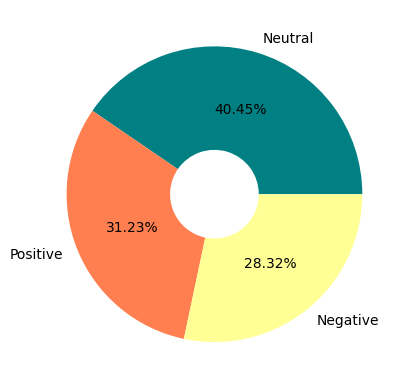

In [9]:
plt.pie(train_data['sentiment'].value_counts(),labels=['Neutral','Positive','Negative'], autopct='%1.2f%%',
            colors=['#008083','#FF7F50','#FFFF96'],wedgeprops=dict(width=0.7))
plt.show()

- The dataset for sentiment analysis is fairly balanced, with 40.45% of the tweets labeled as neutral, 31.23% as positive, and 28.32% as negative. This distribution indicates that the model will have a relatively balanced amount of data for each sentiment category, which can help in achieving a more generalized and accurate model.

In [10]:
positive_data=train_data[train_data['sentiment']=='positive']

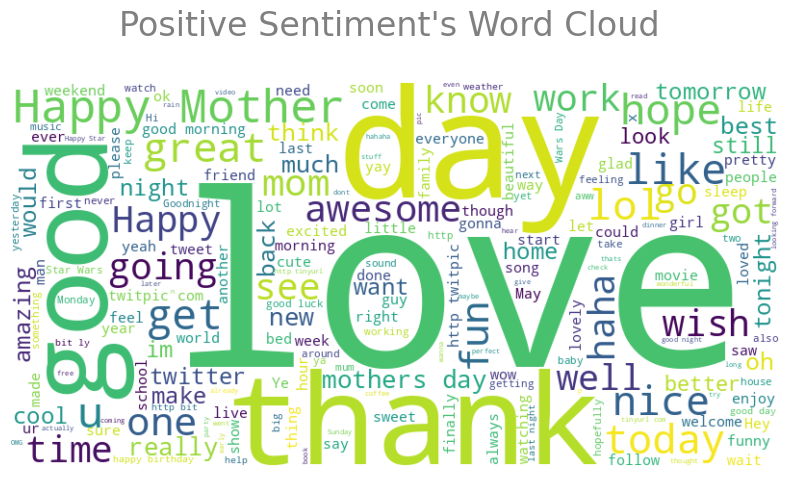

In [11]:
text = ' '.join(positive_data['text'].astype(str))


stop_words = set(stopwords.words('english'))
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title("Positive Sentiment's Word Cloud \n",fontsize=24,color='grey')
plt.axis('off')  # Turn off the axis
plt.show()

- The word cloud for positive sentiments shows that the most frequently occurring words in positive tweets include "love," "thank," "happy," "great," and "day." These words reflect common expressions of positive emotions and sentiments in the dataset, indicating that the model can focus on these kind of key terms to effectively identify positive sentiment in tweets.

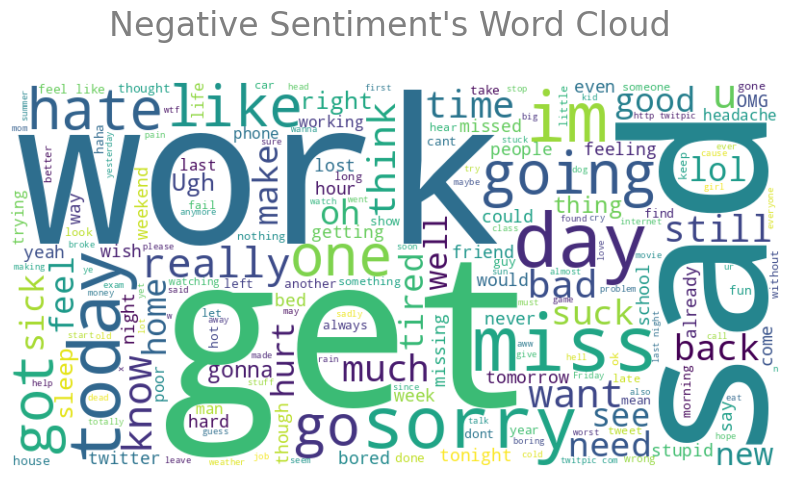

In [12]:
negative_data=train_data[train_data['sentiment']=='negative']
text = ' '.join(negative_data['text'].astype(str))
stop_words = set(stopwords.words('english'))
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Negative Sentiment's Word Cloud \n",fontsize=24,color='grey')
plt.axis('off')  # Turn off the axis
plt.show()

- The word cloud for negative sentiments shows that the most frequently occurring words in negative tweets include "work," "get," "hate," "miss," and "going." These words reflect common expressions of negative emotions and sentiments in the dataset, indicating that the model can focus on these key terms to effectively identify negative sentiment in tweets.

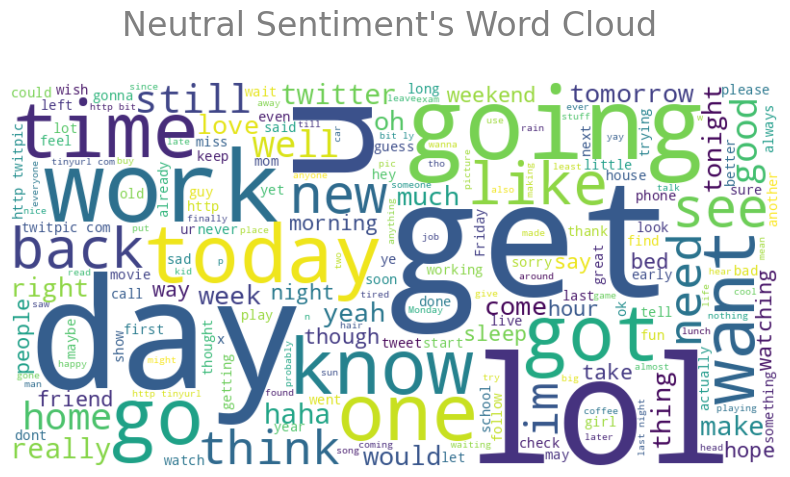

In [13]:
neutral_data=train_data[train_data['sentiment']=='neutral']
text = ' '.join(neutral_data['text'].astype(str))
stop_words = set(stopwords.words('english'))
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Neutral Sentiment's Word Cloud \n",fontsize=24,color='grey')
plt.axis('off')  # Turn off the axis
plt.show()

- The word cloud for neutral sentiments shows that the most frequently occurring words in neutral tweets include "day," "get," "going," "work," and "today." These words reflect common expressions of everyday activities and neutral statements, indicating that the model can focus on these key terms to effectively identify neutral sentiment in tweets.

In [14]:
train_data['Time of Tweet'].value_counts()

morning    9161
noon       9160
night      9159
Name: Time of Tweet, dtype: int64

/tmp/ipykernel_856/1573473427.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_data = grouped_data.pivot('Time of Tweet', 'sentiment', 'count').fillna(0)


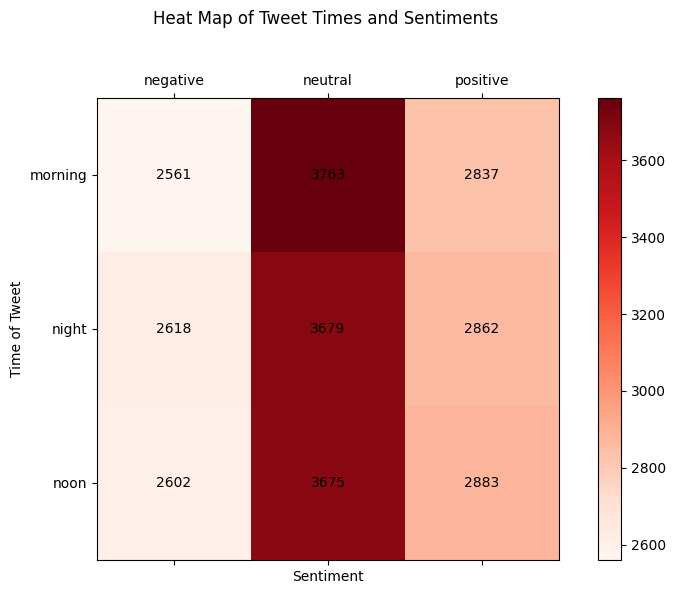

In [15]:
grouped_data = train_data.groupby(['Time of Tweet', 'sentiment']).size().reset_index(name='count')
pivot_data = grouped_data.pivot('Time of Tweet', 'sentiment', 'count').fillna(0)
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.matshow(pivot_data, cmap='Reds')
fig.colorbar(cax)
ax.set_xticks(np.arange(len(pivot_data.columns)))
ax.set_yticks(np.arange(len(pivot_data.index)))
ax.set_xticklabels(pivot_data.columns)
ax.set_yticklabels(pivot_data.index)
for (i, j), val in np.ndenumerate(pivot_data.values):
    ax.text(j, i, int(val), ha='center', va='center', color='black')
plt.xlabel('Sentiment')
plt.ylabel('Time of Tweet')
plt.title('Heat Map of Tweet Times and Sentiments \n\n')
plt.show()

- The heatmap shows that tweets with neutral sentiments are the most frequent across all times of the day (morning, noon, night), with the highest concentration occurring at night. Positive sentiments are more common in the morning and noon, while negative sentiments are relatively evenly distributed throughout the day. This indicates a general trend of higher neutral sentiment activity in the dataset, particularly during nighttime hours.

/tmp/ipykernel_856/2668196745.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_data = grouped_data.pivot('Age of User', 'sentiment', 'count').fillna(0)


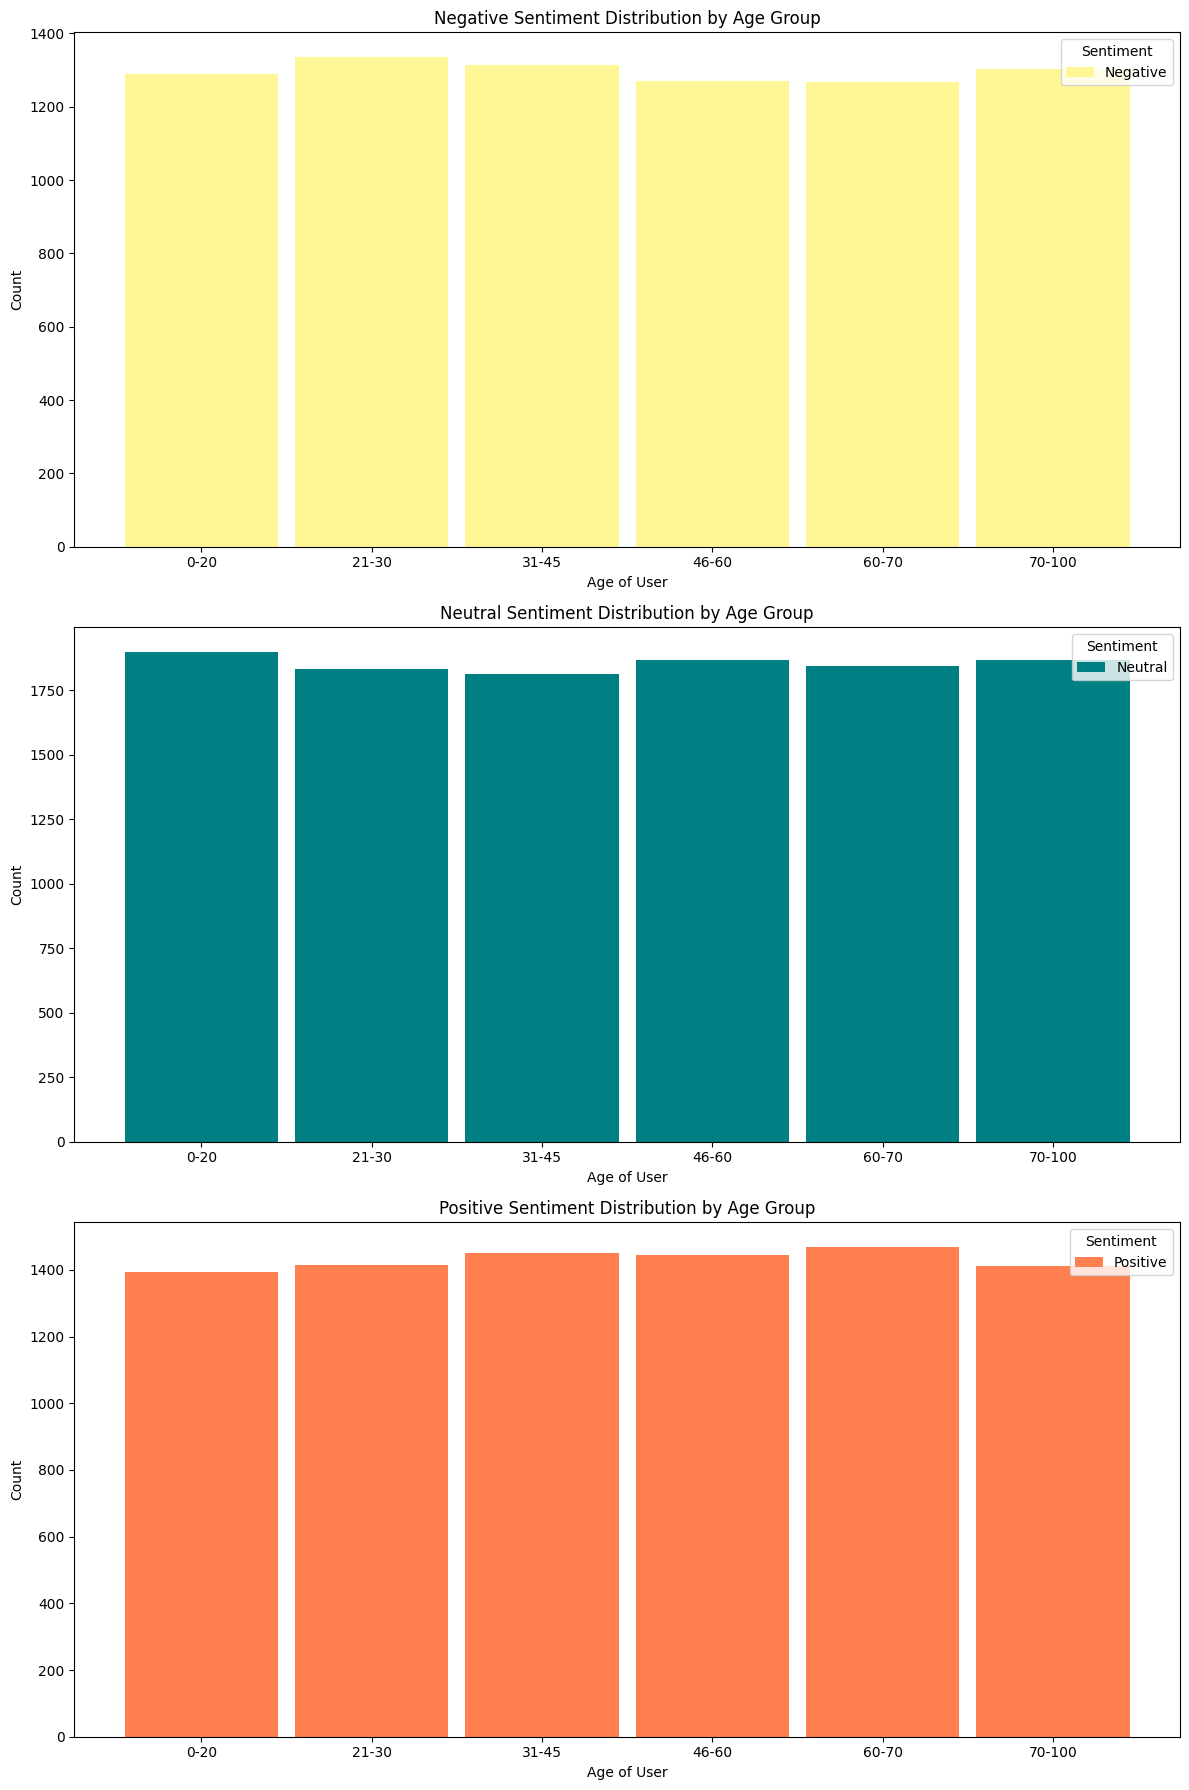

In [16]:
grouped_data = train_data.groupby(['Age of User', 'sentiment']).size().reset_index(name='count')
pivot_data = grouped_data.pivot('Age of User', 'sentiment', 'count').fillna(0)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

# Define bar width
bar_width = 0.9

# Plot each sentiment separately
sentiments = ['negative', 'neutral', 'positive']
colors = ['#FFF796', '#008083', '#FF7F50']

for ax, sentiment, color in zip(axes, sentiments, colors):
    ax.bar(pivot_data.index, pivot_data[sentiment], bar_width, color=color, label=sentiment.capitalize())
    ax.set_title(f'{sentiment.capitalize()} Sentiment Distribution by Age Group')
    ax.set_xlabel('Age of User')
    ax.set_ylabel('Count')
    ax.set_xticks(np.arange(len(pivot_data.index)))
    ax.set_xticklabels(pivot_data.index, rotation=0)
    ax.legend(title='Sentiment')

# Adjust layout
plt.tight_layout()
plt.show()

- The distribution of negative sentiments is fairly uniform across all age groups, indicating that negative sentiments are consistently expressed by users of all ages.

- The distribution of neutral sentiments is also relatively uniform across all age groups, but the counts are slightly higher compared to negative sentiments, suggesting that users tend to express neutral sentiments more frequently.

- Positive sentiments are uniformly distributed across all age groups, similar to the negative sentiment distribution, with a slightly higher count, indicating a balanced expression of positive sentiments among users of different ages.

In [17]:
from collections import Counter

### Model Building
In this section, we will fine-tune the TinyBERT model for sentiment analysis using a custom dataset of tweets. The steps involved include loading and preprocessing the dataset, creating data loaders for training and validation, defining the model and optimizer, and implementing the training and evaluation loops. Finally, we will save the trained model, tokenizer, and evaluation metrics for future use.

In [21]:
class TextIterableDataset(IterableDataset):
    """
    A custom iterable dataset for text classification.

    Args:
        texts (list): A list of input texts.
        labels (list): A list of corresponding labels.

    Attributes:
        texts (list): A list of input texts.
        labels (list): A list of corresponding labels.
        tokenizer (BertTokenizerFast): The tokenizer used for text preprocessing.

    Methods:
        preprocess_text(text): Preprocesses the input text by tokenizing, removing stopwords, and lemmatizing.
        process_data(text, label): Preprocesses the input text and returns the processed data as a dictionary.
        __iter__(): Iterates over the texts and labels, yielding the processed data for each pair.

    """

    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

    def preprocess_text(self, text):
        """
        Preprocesses the input text by tokenizing, removing stopwords, and lemmatizing.

        Args:
            text (str): The input text to be preprocessed.

        Returns:
            str: The preprocessed text.

        """
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        cleaned_text = ' '.join([lemmatizer.lemmatize(w.lower()) for w in tokens if w.isalpha() and w not in stop_words])
        return cleaned_text

    def process_data(self, text, label):
        """
        Preprocesses the input text and returns the processed data as a dictionary.

        Args:
            text (str): The input text to be preprocessed.
            label (int): The corresponding label for the input text.

        Returns:
            dict: The processed data as a dictionary with keys 'input_ids', 'attention_mask', and 'labels'.

        """
        text = self.preprocess_text(text)
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
        return {'input_ids': encoding['input_ids'].squeeze(0), 'attention_mask': encoding['attention_mask'].squeeze(0), 'labels': torch.tensor(label)}

    def __iter__(self):
        """
        Iterates over the texts and labels, yielding the processed data for each pair.

        Yields:
            dict: The processed data as a dictionary with keys 'input_ids', 'attention_mask', and 'labels'.

        """
        for text, label in zip(self.texts, self.labels):
            yield self.process_data(text, label)

def collate_fn(batch):
    """
    Collate function for batching data.

    Args:
        batch (list): A list of dictionaries, where each dictionary represents a single data sample.

    Returns:
        dict: A dictionary containing the batched data with keys 'input_ids', 'attention_mask', and 'labels'.
    """
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['labels'] for item in batch])
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

def load_dataset(file_path):
    """
    Loads the dataset from a CSV file.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        tuple: A tuple containing the list of texts and the list of sentiments.

    """
    try:
        df = pd.read_csv(file_path, dtype=str, low_memory=False, encoding='latin1')
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(file_path, dtype=str, low_memory=False, encoding='ISO-8859-1')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, dtype=str, low_memory=False, encoding='latin1')
    
    df.dropna(subset=['text', 'sentiment'], inplace=True)
    sentiment_mapping = {'neutral': 0, 'negative': 1, 'positive': 2}
    df['sentiment'] = df['sentiment'].map(sentiment_mapping)    
    df.dropna(subset=['sentiment'], inplace=True)
    df['sentiment'] = df['sentiment'].astype(int)
    return df['text'].tolist(), df['sentiment'].tolist()

def train(model, train_loader, optimizer, device, scaler):
    """
    Trains the model on the training data.

    Args:
        model (BertForSequenceClassification): The model to be trained.
        train_loader (DataLoader): The data loader for the training data.
        optimizer (AdamW): The optimizer used for training.
        device (torch.device): The device to be used for training.
        scaler (GradScaler): The gradient scaler for mixed precision training.

    """
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

def evaluate(model, data_loader, device):
    """
    Evaluates the model on the validation or test data.

    Args:
        model (BertForSequenceClassification): The model to be evaluated.
        data_loader (DataLoader): The data loader for the validation or test data.
        device (torch.device): The device to be used for evaluation.

    Returns:
        tuple: A tuple containing the accuracy, precision, recall, and F1 score.

    """
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions.extend(torch.argmax(outputs.logits, -1).tolist())
            true_labels.extend(labels.tolist())
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    return accuracy, precision, recall, f1

def save_model_and_tokenizer(model, tokenizer, model_path, tokenizer_path):
    """
    Saves the model and tokenizer to the specified paths.

    Args:
        model (BertForSequenceClassification): The model to be saved.
        tokenizer (BertTokenizerFast): The tokenizer to be saved.
        model_path (str): The path to save the model.
        tokenizer_path (str): The path to save the tokenizer.

    """
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    model.save_pretrained(model_path)
    if not os.path.exists(tokenizer_path):
        os.makedirs(tokenizer_path)
    tokenizer.save_pretrained(tokenizer_path)

def save_test_data_as_csv(test_texts, test_labels, file_path):
    """
    Saves the test data as a CSV file.

    Args:
        test_texts (list): The list of test texts.
        test_labels (list): The list of test labels.
        file_path (str): The path to save the CSV file.

    """
    df_test = pd.DataFrame({'text': test_texts, 'label': test_labels})
    df_test.to_csv(f"{file_path}/test_dataset.csv", index=False)

def save_evaluation_metrics_as_json(metrics, file_path):
    """
    Saves the evaluation metrics as a JSON file.

    Args:
        metrics (tuple): A tuple containing the evaluation metrics.
        file_path (str): The path to save the JSON file.

    """
    with open(f"{file_path}/evaluation_metrics.json", 'w') as f:
        json.dump(metrics, f)

# Main function
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset
    file_path = 'data/train.csv'
    texts, labels = load_dataset(file_path)

    # Split dataset
    train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
    val_texts, test_texts, val_labels, test_labels = train_test_split(test_texts, test_labels, test_size=0.5, random_state=42)

    # Create datasets and data loaders
    train_dataset = TextIterableDataset(train_texts, train_labels)
    val_dataset = TextIterableDataset(val_texts, val_labels)
    test_dataset = TextIterableDataset(test_texts, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn)

    # Train and evaluate model
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)
    optimizer = AdamW(model.parameters(), lr=5e-5)
    scaler = GradScaler()

    for epoch in range(3):
        train(model, train_loader, optimizer, device, scaler)
        accuracy, precision, recall, f1 = evaluate(model, val_loader, device)
        print(f'Epoch {epoch+1}, Val Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

    metrics = evaluate(model, test_loader, device)
    print(f'Test Accuracy: {metrics[0]:.4f}, Precision: {metrics[1]:.4f}, Recall: {metrics[2]:.4f}, F1: {metrics[3]:.4f}')

    # Save model, tokenizer, test data, and evaluation metrics
    model_save_path = 'Sentiment_Analysis'
    save_model_and_tokenizer(model, BertTokenizerFast.from_pretrained('bert-base-uncased'), model_path=model_save_path, tokenizer_path=model_save_path)
    save_test_data_as_csv(test_texts, test_labels, model_save_path)
    save_evaluation_metrics_as_json(metrics, model_save_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jupyter/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Val Accuracy: 0.7431, Precision: 0.7593, Recall: 0.7431, F1: 0.7428
Epoch 2, Val Accuracy: 0.7365, Precision: 0.7513, Recall: 0.7365, F1: 0.7368
Epoch 3, Val Accuracy: 0.7329, Precision: 0.7397, Recall: 0.7329, F1: 0.7333
Test Accuracy: 0.7431, Precision: 0.7528, Recall: 0.7431, F1: 0.7442


In [23]:

# Import libraries
import torch
from transformers import BertTokenizerFast, BertForSequenceClassification
import numpy as np

def preprocess_text(text, tokenizer, max_len=512):
    """
    Preprocesses the input text by tokenizing it using the provided tokenizer.

    Args:
        text (str): The input text to be preprocessed.
        tokenizer (Tokenizer): The tokenizer object used for tokenization.
        max_len (int, optional): The maximum length of the tokenized sequence. Defaults to 512.

    Returns:
        tokens (Tensor): The tokenized and preprocessed text as a PyTorch tensor.
    """
    tokens = tokenizer(text, padding='max_length', truncation=True, max_length=max_len, return_tensors="pt")
    return tokens

def predict_sentiment(text, model, tokenizer):
    """
    Predicts the sentiment of the given text using the provided model and tokenizer.

    Args:
        text (str): The input text to analyze.
        model: The pre-trained sentiment analysis model.
        tokenizer: The tokenizer used to preprocess the text.

    Returns:
        predicted_class (numpy.ndarray): The predicted sentiment class.
        confidence (numpy.ndarray): The confidence scores for each sentiment class.
        probabilities (numpy.ndarray): The probability distribution over all sentiment classes.
    """
    preprocessed_text = preprocess_text(text, tokenizer)
    input_ids = preprocessed_text['input_ids']
    attention_mask = preprocessed_text['attention_mask']

    input_ids = input_ids.to(model.device)
    attention_mask = attention_mask.to(model.device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        confidence, predicted_class = torch.max(probabilities, dim=-1)

    return predicted_class.cpu().numpy(), confidence.cpu().numpy(), probabilities.cpu().numpy()

# Load the pre-trained sentiment analysis model and tokenizer
model_path = 'Sentiment_Analysis'
model = BertForSequenceClassification.from_pretrained(model_path).to('cuda')
tokenizer = BertTokenizerFast.from_pretrained(model_path)

# Perform sentiment analysis on user input
while True:
    # Get user input
    text = input("\nEnter text for sentiment analysis (or type 'exit' to stop): ")

    # Check if the user wants to exit
    if text.lower() == 'exit':
        print("Exiting sentiment analysis.")
        break

    # Predict the sentiment of the input text
    predicted_class, confidence, probabilities = predict_sentiment(text, model, tokenizer)
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

    # Display the predicted sentiment and confidence
    print(f"\nSentiment: {sentiment_labels[predicted_class.item()]}")
    print(f"Confidence: {confidence.item() * 100:.2f}%")

    # Display the probability distribution over all sentiment classes
    print("Probabilities:")
    for sentiment, probability in zip(sentiment_labels.values(), probabilities[0]):
        print(f"  {sentiment}: {probability.item() * 100:.2f}%")



Enter text for sentiment analysis (or type 'exit' to stop):  I like you



Sentiment: Positive
Confidence: 82.09%
Probabilities:
  Negative: 8.79%
  Neutral: 9.12%
  Positive: 82.09%



Enter text for sentiment analysis (or type 'exit' to stop):  I don't like you



Sentiment: Neutral
Confidence: 98.35%
Probabilities:
  Negative: 1.21%
  Neutral: 98.35%
  Positive: 0.44%



Enter text for sentiment analysis (or type 'exit' to stop):  exit


Exiting sentiment analysis.
